In [7]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error


from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks


import warnings
warnings.filterwarnings('ignore')

In [ ]:
%pip install openpyxl
%pip install tensorflow

-------------------------------

Prepare data 

In [4]:
#  Load the climate data

file_path = "Kalam Climate Data.xlsx"   
climate_df = pd.read_excel(file_path)

climate_df['Date Time'] = pd.to_datetime(climate_df['Date Time'])

# Extract date

climate_df['date'] = climate_df['Date Time'].dt.date

# Daily aggregation
daily_climate = climate_df.groupby('date').agg({
    'Temperature (°C)': ['mean', 'min', 'max'],
    'Dewpoint Temperature (°C)': ['mean', 'min', 'max'],
    'U Wind Component (m/s)': 'mean',
    'V Wind Component (m/s)': 'mean',
    'Total Precipitation (mm)': 'sum',
    'Snowfall (mm)': 'sum',
    'Snow Cover (%)': 'mean'
})

# Flatten columns
daily_climate.columns = ['_'.join(col).strip() for col in daily_climate.columns.values]

# Reset index
daily_climate = daily_climate.reset_index()

# Define start and end dates
start_date = pd.to_datetime('2024-09-24')
end_date   = pd.to_datetime('2024-10-24')

daily_climate["date"] = pd.to_datetime(daily_climate["date"])

# Filter DataFrame
extra_month_df = daily_climate[(daily_climate['date'] >= start_date) & (daily_climate['date'] <= end_date)]


new_names = {
    'date': 'Date',
    'Temperature (°C)_mean': 'Temp_Mean',
    'Temperature (°C)_min': 'Temp_Min',
    'Temperature (°C)_max': 'Temp_Max',
    'Dewpoint Temperature (°C)_mean': 'Dewpoint_Mean',
    'Dewpoint Temperature (°C)_min': 'Dewpoint_Min',
    'Dewpoint Temperature (°C)_max': 'Dewpoint_Max',
    'U Wind Component (m/s)_mean': 'U_Wind_Mean',
    'V Wind Component (m/s)_mean': 'V_Wind_Mean',
    'Total Precipitation (mm)_sum': 'Precipitation_Sum',
    'Snowfall (mm)_sum': 'Snowfall_Sum',
    'Snow Cover (%)_mean': 'SnowCover_Mean'
}


extra_month_df.rename(columns=new_names, inplace=True)

all_data_df = pd.read_csv("Data.csv")

all_data_df.drop(columns=["consumer_device_9", "consumer_device_x", "v_red", "v_blue","v_yellow", "current", "power_factor"], inplace=True)
all_data_df.head()

# Ensure datetime
all_data_df['date_time'] = pd.to_datetime(all_data_df['date_time'])


# Extract date (drop time)
all_data_df['date'] = all_data_df['date_time'].dt.date


# Group by Source (consumer_device + data_user) and date

daily_df = all_data_df.groupby(['Source', 'date']).agg({
    'kwh': 'sum'  
})

daily_df = daily_df.reset_index()


# Ensure datetime index
daily_df = daily_df.set_index("date").sort_index()
daily_climate = daily_climate.set_index("date").sort_index()

# Merge
merged_daily_df = daily_df.join(daily_climate, how="left")


merged_daily_df.reset_index(inplace=True)

merged_daily_df.to_csv("second_daily_merged_hydro_climate.csv", index=False)


# Dictionary mapping old names to new names
new_names = {
    'date': 'Date',
    'Source': 'Source',
    'kwh': 'kwh',
    'Temperature (°C)_mean': 'Temp_Mean',
    'Temperature (°C)_min': 'Temp_Min',
    'Temperature (°C)_max': 'Temp_Max',
    'Dewpoint Temperature (°C)_mean': 'Dewpoint_Mean',
    'Dewpoint Temperature (°C)_min': 'Dewpoint_Min',
    'Dewpoint Temperature (°C)_max': 'Dewpoint_Max',
    'U Wind Component (m/s)_mean': 'U_Wind_Mean',
    'V Wind Component (m/s)_mean': 'V_Wind_Mean',
    'Total Precipitation (mm)_sum': 'Precipitation_Sum',
    'Snowfall (mm)_sum': 'Snowfall_Sum',
    'Snow Cover (%)_mean': 'SnowCover_Mean'
}

merged_daily_df.rename(columns=new_names, inplace=True)

----------------------------------

# Let us train a Feed-Forward Neural Network (MLP)

# 1 st Approach: -----> Zindi Score 4.928191196 kWh

Feature Engineering 

In [ ]:
def add_features(df):
    df = df.copy()
    df["Temp_dew_diff"] = df["Temp_Mean"] - df["Dewpoint_Mean"]
    df["wind_speed"] = np.sqrt(df["U_Wind_Mean"]**2 + df["V_Wind_Mean"]**2)
    df["precip_snow_ratio"] = df["Precipitation_Sum"] / (df["Snowfall_Sum"] + 1e-6)
    return df

def add_lag_roll(df, group_col="Source", target_col="kwh", lags=[1,2,7], windows=[3,7]):
    df = df.sort_values(["Source","Date"]).copy()
    for lag in lags:
        df[f"lag_{lag}"] = df.groupby(group_col)[target_col].shift(lag)
    for w in windows:
        df[f"roll_mean_{w}"] = df.groupby(group_col)[target_col].shift(1).rolling(w).mean()
    return df

In [ ]:
# --- Reindex all Sources across full date range ---
def reindex_sources(df):
    all_dates = pd.date_range(df["Date"].min(), df["Date"].max())
    all_sources = df["Source"].unique()
    idx = pd.MultiIndex.from_product([all_sources, all_dates], names=["Source","Date"])
    df_full = df.set_index(["Source","Date"]).reindex(idx).reset_index()
    df_full["kwh"] = df_full["kwh"].fillna(0)
    climate_cols = [c for c in df.columns if c not in ["Source","kwh","Date"]]
    for c in climate_cols:
        df_full[c] = df_full.groupby("Date")[c].transform("first")
    return df_full


# --- Prepare dataset ---
df = merged_daily_df.copy()
df["Date"] = pd.to_datetime(df["Date"])
df = reindex_sources(df)
df = add_features(df)
df = add_lag_roll(df)
df = df.dropna().reset_index(drop=True)

feature_cols = [
    "Temp_Mean","Temp_Min","Temp_Max","Dewpoint_Mean","Dewpoint_Min","Dewpoint_Max",
    "U_Wind_Mean","V_Wind_Mean","Precipitation_Sum","Snowfall_Sum","SnowCover_Mean",
    "Temp_dew_diff","wind_speed","precip_snow_ratio",
] + [c for c in df.columns if c.startswith("lag_") or c.startswith("roll_")]

X = df[feature_cols].values
y = df["kwh"].values



# Scale features for neural net
scaler = StandardScaler()
X = scaler.fit_transform(X)




Modeling

In [ ]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Build MLP model ---
def create_mlp(input_dim):
    model = models.Sequential()
    model.add(layers.Dense(128, activation="relu", input_dim=input_dim))
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dense(32, activation="relu"))
    model.add(layers.Dense(1, activation="relu"))  # relu ensures no negative kwh
    model.compile(optimizer="adam", loss="mse", metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

mlp = create_mlp(X_train.shape[1])

# --- Callbacks: EarlyStopping + ReduceLROnPlateau ---
early_stop = callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True, verbose=1
)
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1
)

history = mlp.fit(
    X_train, y_train,
    validation_data=(X_test,y_test),
    epochs=100, batch_size=256, verbose=1,
    callbacks=[early_stop, reduce_lr]
)

# Predict on test
y_pred = mlp.predict(X_test).flatten()
y_pred = np.maximum(0, y_pred)  # safety clip

# --- Global Metrics ---
print("=== Global Metrics ===")
rmse = mean_squared_error(y_test, y_pred, squared=False)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Regression: RMSE={rmse:.3f}, MAPE={mape:.3f}\n")





Predict next month (extra climate data) 

In [ ]:

extra = add_features(extra_month_df.copy())
extra["Date"] = pd.to_datetime(extra["Date"])

preds = []
sources = df["Source"].unique()
for src in sources:
    hist = df[df["Source"]==src].copy()
    extra_src = extra.copy()
    extra_src["Source"] = src
    lag_hist = hist.tail(7).reset_index(drop=True)
    rows = []
    for _, row in extra_src.iterrows():
        r = row.to_dict()
        for lag in [1,2,7]:
            if len(lag_hist) >= lag:
                r[f"lag_{lag}"] = lag_hist.loc[len(lag_hist)-lag,"kwh"]
            else:
                r[f"lag_{lag}"] = np.nan
        for w in [3,7]:
            if len(lag_hist) >= w:
                r[f"roll_mean_{w}"] = lag_hist["kwh"].iloc[-w:].mean()
            else:
                r[f"roll_mean_{w}"] = lag_hist["kwh"].mean()
        X_ex = pd.DataFrame([r])[feature_cols].fillna(0)
        X_ex = scaler.transform(X_ex)
        r["pred_kwh"] = max(0, mlp.predict(X_ex)[0,0])
        lag_hist = pd.concat([lag_hist, pd.DataFrame([{"kwh": r["pred_kwh"]}])], ignore_index=True)
        rows.append(r)
    preds.append(pd.DataFrame(rows))
preds_df = pd.concat(preds)


Plots

In [ ]:
"""
# Per Source

def plot_source(src):
    plt.figure(figsize=(12,4))
    d = df[df["Source"]==src]
    plt.plot(d["Date"], d["kwh"], label="actual")
    d_extra = preds_df[preds_df["Source"]==src]
    plt.plot(d_extra["Date"], d_extra["pred_kwh"], "--", label="pred (extra month)")
    plt.title(f"Source {src}")
    plt.legend()
    plt.show()

for src in sources:
    plot_source(src)

"""

In [ ]:
# Overall 

plt.figure(figsize=(12,4))
plt.plot(df.groupby("Date")["kwh"].sum(), label="actual total")
plt.plot(preds_df.groupby("Date")["pred_kwh"].sum(), "--", label="pred total (extra month)")
plt.legend()
plt.show()

Build Submission file

In [ ]:
sub = pd.read_csv("SampleSubmission.csv")
sub["Date"] = sub["ID"].apply(lambda x: x.split("_")[0])
sub["Source"] = sub["ID"].apply(lambda x: "_".join(x.split("_")[1:]))
sub["Date"] = pd.to_datetime(sub["Date"])

preds_out = preds_df.copy()
preds_out["Date"] = pd.to_datetime(preds_out["Date"])

submission = sub.merge(preds_out[["Date","Source","pred_kwh"]], on=["Date","Source"], how="left")
submission = submission[["ID","pred_kwh"]]

submission.to_csv("MySubmission_3_MLP.csv", index=False)
submission

-------------------------

# Second Approach:   performed worse ----> Zindi 6.431916951

1) Add calendar features + longer rolling windows:

- Calendar features (day_of_week, month, is_weekend, season)

- Longer rolling windows (14 and 30 days)

- Exponential moving average (EMA) features

2) Added Dropout (0.2) layers for better generalization.

3) Extended lag history to 30 days when predicting extra month.

In [ ]:


# Feature Engineering 


def add_features(df):
    df = df.copy()
    # Climate derived features
    df["Temp_dew_diff"] = df["Temp_Mean"] - df["Dewpoint_Mean"]
    df["wind_speed"] = np.sqrt(df["U_Wind_Mean"]**2 + df["V_Wind_Mean"]**2)
    df["precip_snow_ratio"] = df["Precipitation_Sum"] / (df["Snowfall_Sum"] + 1e-6)
    
    # Calendar features
    df["day_of_week"] = df["Date"].dt.dayofweek
    df["month"] = df["Date"].dt.month
    df["is_weekend"] = (df["day_of_week"] >= 5).astype(int)
    # Simple season encoding (1–4)
    df["season"] = ((df["month"] % 12 + 3) // 3)
    
    return df


def add_lag_roll(df, group_col="Source", target_col="kwh", lags=[1,2,7], windows=[3,7,14,30]):
    df = df.sort_values([group_col,"Date"]).copy()
    # Lags
    for lag in lags:
        df[f"lag_{lag}"] = df.groupby(group_col)[target_col].shift(lag)
    # Rolling means
    for w in windows:
        df[f"roll_mean_{w}"] = df.groupby(group_col)[target_col].shift(1).rolling(w).mean()
    # Exponential moving averages
    for span in [7,14,30]:
        df[f"ema_{span}"] = df.groupby(group_col)[target_col].shift(1).ewm(span=span, adjust=False).mean()
    return df


def add_source_stats(df, group_col="Source", target_col="kwh"):
    stats = df.groupby(group_col)[target_col].agg(["mean","median"]).reset_index()
    stats.columns = [group_col, "src_mean_kwh", "src_median_kwh"]
    df = df.merge(stats, on=group_col, how="left")
    return df


def reindex_sources(df):
    all_dates = pd.date_range(df["Date"].min(), df["Date"].max())
    all_sources = df["Source"].unique()
    idx = pd.MultiIndex.from_product([all_sources, all_dates], names=["Source","Date"])
    df_full = df.set_index(["Source","Date"]).reindex(idx).reset_index()
    df_full["kwh"] = df_full["kwh"].fillna(0)
    climate_cols = [c for c in df.columns if c not in ["Source","kwh","Date"]]
    for c in climate_cols:
        df_full[c] = df_full.groupby("Date")[c].transform("first")
    return df_full



#  Prepare dataset 


df = merged_daily_df.copy()
df["Date"] = pd.to_datetime(df["Date"])
df = reindex_sources(df)
df = add_features(df)
df = add_lag_roll(df)
df = add_source_stats(df)
df = df.dropna().reset_index(drop=True)

# Features
feature_cols = [
    "Temp_Mean","Temp_Min","Temp_Max","Dewpoint_Mean","Dewpoint_Min","Dewpoint_Max",
    "U_Wind_Mean","V_Wind_Mean","Precipitation_Sum","Snowfall_Sum","SnowCover_Mean",
    "Temp_dew_diff","wind_speed","precip_snow_ratio",
    "day_of_week","month","is_weekend","season",
    "src_mean_kwh","src_median_kwh"
] + [c for c in df.columns if c.startswith("lag_") or c.startswith("roll_") or c.startswith("ema_")]

X = df[feature_cols].values
y = df["kwh"].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


#  Build MLP model 


def create_mlp(input_dim):
    model = models.Sequential()
    model.add(layers.Dense(128, activation="relu", input_dim=input_dim))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(32, activation="relu"))
    model.add(layers.Dense(1, activation="relu"))                                                         # Here relu ensures no negative predictions, NO NEED TO WORRY ABOUT IT !
    model.compile(optimizer="adam", loss="mse", metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

mlp = create_mlp(X_train.shape[1])

early_stop = callbacks.EarlyStopping(
    monitor="val_loss", patience=5, restore_best_weights=True, verbose=1
)
reduce_lr = callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1
)

history = mlp.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100, batch_size=256, verbose=1,
    callbacks=[early_stop, reduce_lr]
)


#  Evaluate on test set 

y_pred = mlp.predict(X_test).flatten()
y_pred = np.maximum(0, y_pred)

print("=== Global Metrics ===")
rmse = mean_squared_error(y_test, y_pred, squared=False)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Regression: RMSE={rmse:.3f}, MAPE={mape:.3f}\n")




Epoch 1/100
821/821 ━━━━━━━━━━━━━━━━━━━━ 13s 10ms/step - loss: 2.2619 - root_mean_squared_error: 1.5040 - val_loss: 1.7733 - val_root_mean_squared_error: 1.3317 - learning_rate: 0.0010
Epoch 2/100
821/821 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 1.8603 - root_mean_squared_error: 1.3639 - val_loss: 1.6089 - val_root_mean_squared_error: 1.2684 - learning_rate: 0.0010
Epoch 3/100
821/821 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 1.8401 - root_mean_squared_error: 1.3565 - val_loss: 1.7014 - val_root_mean_squared_error: 1.3044 - learning_rate: 0.0010
Epoch 4/100
821/821 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - loss: 1.8309 - root_mean_squared_error: 1.3531 - val_loss: 1.6745 - val_root_mean_squared_error: 1.2940 - learning_rate: 0.0010
Epoch 5/100
820/821 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.7012 - root_mean_squared_error: 1.3011
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
821/821 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - loss: 1.8223 - root_mean_squared_error: 1.

In [ ]:

#  Predict extra month 

extra = add_features(extra_month_df.copy())
extra["Date"] = pd.to_datetime(extra["Date"])

preds = []
sources = df["Source"].unique()
for src in sources:
    hist = df[df["Source"]==src].copy()
    extra_src = extra.copy()
    extra_src["Source"] = src
    lag_hist = hist.tail(30).reset_index(drop=True)  # keep last 30 days
    rows = []
    for _, row in extra_src.iterrows():
        r = row.to_dict()
        # Lags
        for lag in [1,2,7]:
            if len(lag_hist) >= lag:
                r[f"lag_{lag}"] = lag_hist.loc[len(lag_hist)-lag, "kwh"]
            else:
                r[f"lag_{lag}"] = 0
        # Rolling means
        for w in [3,7,14,30]:
            if len(lag_hist) >= w:
                r[f"roll_mean_{w}"] = lag_hist["kwh"].iloc[-w:].mean()
            else:
                r[f"roll_mean_{w}"] = lag_hist["kwh"].mean()
        # EMA
        for span in [7,14,30]:
            r[f"ema_{span}"] = lag_hist["kwh"].ewm(span=span, adjust=False).mean().iloc[-1]
        # Source stats
        r["src_mean_kwh"] = hist["kwh"].mean()
        r["src_median_kwh"] = hist["kwh"].median()
        # Predict
        X_ex = pd.DataFrame([r])[feature_cols].fillna(0)
        X_ex = scaler.transform(X_ex)
        r["pred_kwh"] = max(0, mlp.predict(X_ex, verbose=0)[0,0])
        lag_hist = pd.concat([lag_hist, pd.DataFrame([{"kwh": r["pred_kwh"]}])], ignore_index=True)
        rows.append(r)
    preds.append(pd.DataFrame(rows))
preds_df = pd.concat(preds)



In [ ]:

# Prepare submission 

sub = pd.read_csv("SampleSubmission.csv")
sub["Date"] = sub["ID"].apply(lambda x: x.split("_")[0])
sub["Source"] = sub["ID"].apply(lambda x: "_".join(x.split("_")[1:]))
sub["Date"] = pd.to_datetime(sub["Date"])

preds_out = preds_df.copy()
preds_out["Date"] = pd.to_datetime(preds_out["Date"])

submission = sub.merge(preds_out[["Date","Source","pred_kwh"]], on=["Date","Source"], how="left")
submission = submission[["ID","pred_kwh"]]
submission.to_csv("MySubmission_5_MLP.csv", index=False)

✅ Submission saved to MySubmission_ImprovedMLP.csv


-------------------------------

# Third approach -----> zindi 4.50048738  (4th Position !!)

Let us not apply all the changes together, but one ba one. Let us try first only adding the drop uot layers

Epoch 1/100
863/863 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - loss: 2.0037 - root_mean_squared_error: 1.4155 - val_loss: 1.7968 - val_root_mean_squared_error: 1.3404 - learning_rate: 0.0010
Epoch 2/100
863/863 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 1.8228 - root_mean_squared_error: 1.3501 - val_loss: 1.8228 - val_root_mean_squared_error: 1.3501 - learning_rate: 0.0010
Epoch 3/100
863/863 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 1.7367 - root_mean_squared_error: 1.3178 - val_loss: 1.7607 - val_root_mean_squared_error: 1.3269 - learning_rate: 0.0010
Epoch 4/100
863/863 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 1.7453 - root_mean_squared_error: 1.3211 - val_loss: 1.7335 - val_root_mean_squared_error: 1.3166 - learning_rate: 0.0010
Epoch 5/100
863/863 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 1.6488 - root_mean_squared_error: 1.2841 - val_loss: 1.7504 - val_root_mean_squared_error: 1.3230 - learning_rate: 0.0010
Epoch 6/100
863/863 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 1.6740 - root_mean_squar

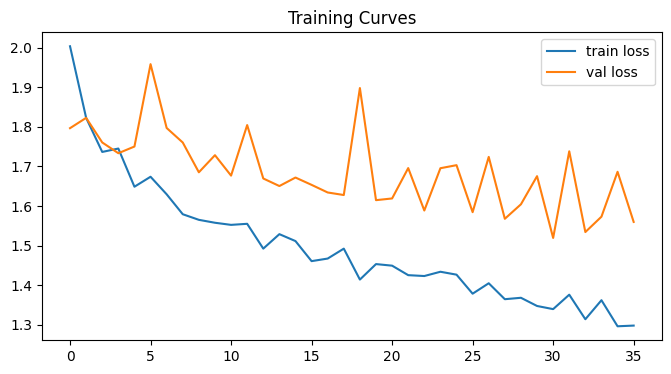

In [ ]:
# Feature engineering (unchanged)

def add_features(df):
    df = df.copy()
    df["Temp_dew_diff"] = df["Temp_Mean"] - df["Dewpoint_Mean"]
    df["wind_speed"] = np.sqrt(df["U_Wind_Mean"]**2 + df["V_Wind_Mean"]**2)
    df["precip_snow_ratio"] = df["Precipitation_Sum"] / (df["Snowfall_Sum"] + 1e-6)
    return df

def add_lag_roll(df, group_col="Source", target_col="kwh", lags=[1,2,7], windows=[3,7]):
    df = df.sort_values([group_col,"Date"]).copy()
    for lag in lags:
        df[f"lag_{lag}"] = df.groupby(group_col)[target_col].shift(lag)
    for w in windows:
        df[f"roll_mean_{w}"] = df.groupby(group_col)[target_col].shift(1).rolling(w).mean()
    return df

def reindex_sources(df):
    all_dates = pd.date_range(df["Date"].min(), df["Date"].max())
    all_sources = df["Source"].unique()
    idx = pd.MultiIndex.from_product([all_sources, all_dates], names=["Source","Date"])
    df_full = df.set_index(["Source","Date"]).reindex(idx).reset_index()
    df_full["kwh"] = df_full["kwh"].fillna(0)
    climate_cols = [c for c in df.columns if c not in ["Source","kwh","Date"]]
    for c in climate_cols:
        df_full[c] = df_full.groupby("Date")[c].transform("first")
    return df_full


# Prepare dataset

df = merged_daily_df.copy()
df["Date"] = pd.to_datetime(df["Date"])
df = reindex_sources(df)                
df = add_features(df)
df = add_lag_roll(df)
df = df.dropna().reset_index(drop=True) 

feature_cols = [
    "Temp_Mean","Temp_Min","Temp_Max","Dewpoint_Mean","Dewpoint_Min","Dewpoint_Max",
    "U_Wind_Mean","V_Wind_Mean","Precipitation_Sum","Snowfall_Sum","SnowCover_Mean",
    "Temp_dew_diff","wind_speed","precip_snow_ratio",
] + [c for c in df.columns if c.startswith("lag_") or c.startswith("roll_")]

# train/test split 
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=True)

# scale features for MLP
scaler = StandardScaler()
X_train = scaler.fit_transform(train_df[feature_cols])
y_train = train_df["kwh"].values
X_test = scaler.transform(test_df[feature_cols])
y_test = test_df["kwh"].values

# -------------------------
# MLP model (only addition: Dropout) !!
# -------------------------
def create_mlp_with_dropout(input_dim):
    model = models.Sequential()
    model.add(layers.Dense(128, activation="relu", input_dim=input_dim))
    model.add(layers.Dropout(0.2))            # <-- added dropout
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dropout(0.2))            # <-- added dropout
    model.add(layers.Dense(32, activation="relu"))
    model.add(layers.Dense(1, activation="relu"))  # ReLU to avoid negative predictions
    model.compile(optimizer="adam", loss="mse", metrics=[tf.keras.metrics.RootMeanSquaredError()])
    return model

mlp = create_mlp_with_dropout(X_train.shape[1])

early_stop = callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True, verbose=1)
reduce_lr = callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6, verbose=1)

history = mlp.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100, batch_size=256, verbose=1,
    callbacks=[early_stop, reduce_lr]
)


# Evaluate on test set

y_pred = mlp.predict(X_test).flatten()
y_pred = np.maximum(0, y_pred)   

print("=== Global Metrics ===")
rmse = mean_squared_error(y_test, y_pred, squared=False)
mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"Regression: RMSE={rmse:.4f}, MAPE={mape:.4f}\n")

# per-source metrics on TEST (helpful to compare!)
per_source = []
for src in sorted(df["Source"].unique()):
    t_src = test_df[test_df["Source"] == src]
    if t_src.shape[0] == 0:
        continue
    # build X for this source in test_df order
    X_src = scaler.transform(t_src[feature_cols])
    y_src = t_src["kwh"].values
    y_src_pred = np.maximum(0, mlp.predict(X_src).flatten())
    rm = mean_squared_error(y_src, y_src_pred, squared=False)
    mp = mean_absolute_percentage_error(y_src, y_src_pred)
    per_source.append((src, rm, mp, len(t_src)))
per_source_df = pd.DataFrame(per_source, columns=["Source","RMSE","MAPE","N_test_rows"])
print("Per-source TEST sample (first rows):")
print(per_source_df.head(10).to_string(index=False))

# Let us see the training curves
plt.figure(figsize=(8,4))
plt.plot(history.history["loss"], label="train loss")
plt.plot(history.history["val_loss"], label="val loss")
plt.legend(); plt.title("Training Curves"); plt.show()



In [ ]:

# Extra-month predictions 

extra = add_features(extra_month_df.copy())
extra["Date"] = pd.to_datetime(extra["Date"])

preds = []
sources = df["Source"].unique()
for src in sources:
    hist = df[df["Source"]==src].copy()
    extra_src = extra.copy()
    extra_src["Source"] = src
    lag_hist = hist.tail(7).reset_index(drop=True)  # last 7 days to compute lags/rolls
    rows = []
    for _, row in extra_src.iterrows():
        r = row.to_dict()
        # lags
        for lag in [1,2,7]:
            if len(lag_hist) >= lag:
                r[f"lag_{lag}"] = lag_hist.loc[len(lag_hist)-lag, "kwh"]
            else:
                r[f"lag_{lag}"] = 0
        # rolling means
        for w in [3,7]:
            if len(lag_hist) >= w:
                r[f"roll_mean_{w}"] = lag_hist["kwh"].iloc[-w:].mean()
            else:
                r[f"roll_mean_{w}"] = lag_hist["kwh"].mean() if len(lag_hist)>0 else 0
        # predict
        X_ex = pd.DataFrame([r])[feature_cols].fillna(0)
        X_ex = scaler.transform(X_ex)
        r["pred_kwh"] = float(max(0, mlp.predict(X_ex, verbose=0)[0,0]))
        # append to history so next day uses predicted values as lags
        lag_hist = pd.concat([lag_hist, pd.DataFrame([{"kwh": r["pred_kwh"]}])], ignore_index=True)
        rows.append(r)
    preds.append(pd.DataFrame(rows))
preds_df = pd.concat(preds, ignore_index=True)




In [ ]:
"""


# Diagnostic plots (10 random sources + aggregated)

random.seed(42)
sample_sources = random.sample(list(df["Source"].unique()), min(10, len(df["Source"].unique())))

for src in sample_sources:
    g_true = df[df["Source"] == src].sort_values("Date")
    g_pred = preds_df[preds_df["Source"] == src].sort_values("Date")
    plt.figure(figsize=(10,3))
    plt.plot(g_true["Date"], g_true["kwh"], label="history", color="blue")
    plt.plot(g_pred["Date"], g_pred["pred_kwh"], "--", label="pred extra month", color="red")
    plt.title(f"Source: {src}")
    plt.ylabel("kWh"); plt.legend(); plt.show()

agg_true = df.groupby("Date")["kwh"].sum().reset_index()
agg_pred = preds_df.groupby("Date")["pred_kwh"].sum().reset_index()
plt.figure(figsize=(12,4))
plt.plot(agg_true["Date"], agg_true["kwh"], label="total history", color="blue")
plt.plot(agg_pred["Date"], agg_pred["pred_kwh"], "--", label="total predicted (extra month)", color="red")
plt.legend(); plt.title("Aggregated consumption"); plt.show()

"""

In [10]:
# Prepare submission 

sub = pd.read_csv("SampleSubmission.csv")
sub["Date"] = sub["ID"].apply(lambda x: x.split("_")[0])
sub["Source"] = sub["ID"].apply(lambda x: "_".join(x.split("_")[1:]))
sub["Date"] = pd.to_datetime(sub["Date"])

preds_out = preds_df.copy()
preds_out["Date"] = pd.to_datetime(preds_out["Date"])

submission = sub.merge(preds_out[["Date","Source","pred_kwh"]], on=["Date","Source"], how="left")
submission = submission[["ID","pred_kwh"]]
submission.to_csv("MySubmission_6_MLP.csv", index=False)